In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras import models
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

Using TensorFlow backend.


In [16]:
def generate_prediction():
    
    # read data from the file
    dataset = pd.read_csv('trainData_set1.csv')
    # extracting a single feature
    X0 = dataset.BIDASKIMBALANCE
    # split into train and test
    train, test = split_dataset3(X0.values)
    # evaluate model and get scores
    n_input = 10
    score_lstm, scores_LSTM, predictions_LSTM = evaluate_model(train, test, n_input, 'lstm2_10steps.hdf5')
    score_ED_LSTM, scores_ED_LSTM, predictions_ED = evaluate_model(train, test, n_input, 'ed_lstm_10steps.hdf5')
    score_CNN_LSTM, scores_CNN_LSTM, predictions_CNN = evaluate_model(train, test, n_input, 'cnn_lstm_10steps.hdf5')
    # summarize scores
    # summarize scores
    summarize_scores('LSTM', score_lstm, scores_LSTM)
    summarize_scores('ED_LSTM', score_ED_LSTM, scores_ED_LSTM)
    summarize_scores('CNN_LSTM', score_CNN_LSTM, scores_CNN_LSTM)
    # plot scores
    days = ['s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10']
    pyplot.figure(figsize=(10,5))
    pyplot.plot(days, scores_LSTM, marker='o', label='lstm')
    pyplot.plot(days, scores_ED_LSTM, marker='o', label='ed_lstm')
    pyplot.plot(days, scores_CNN_LSTM, marker='o', label='cnn_lstm')
    pyplot.legend()
    pyplot.show()
    # return predictions
    return predictions_LSTM, predictions_ED, predictions_CNN
    

In [3]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
# split a univariate dataset into train/test sets
def split_dataset3(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[29950:30000], data[30000:45000]
	# restructure into windows of 10-step data
	train = rolling_window(train, 10)
	test = rolling_window(test, 10)
	# place it in a dataframe
	trainDF = pd.DataFrame(data=train)
	testDF = pd.DataFrame(data=test)
	# name columns  
	cols_train = trainDF.columns.tolist()
	cols_test = testDF.columns.tolist()
	# rearrange columns      
	cols_train = cols_train[::-1]
	cols_test = cols_test[::-1]
	# rearrange dataframe   
	trainDF = trainDF[cols_train] 
	testDF = testDF[cols_test]
	# extract values
	train =trainDF.values
	test = testDF.values
	# reshape values    
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [97]:
# split a univariate dataset into train/test sets
def split_dataset3(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[14940:15000], data[15000:30000]
	# restructure into windows of 20-step data
	train = np.array(np.split(train, len(train)/20))
	test = np.array(np.split(test, len(test)/20))
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [25]:
# split a univariate dataset into train/test sets
def split_dataset3(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[0:60], data[60:(max_steps*20)]
	# restructure into windows of 20-step data
	train = np.array(np.split(train, len(train)/20))
	test = np.array(np.split(test, len(test)/20))
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [5]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [6]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [7]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [17]:
# evaluate a single model
def evaluate_model(train, test, n_input, model_name):
	# load model
	model = models.load_model(model_name)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :], predictions)
#	score, scores = 0, 0
	return score, scores, predictions

In [11]:
int(50/20)

2

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
LSTM: [0.132] 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
ED_LSTM: [0.164] 0.2, 0.2, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2
CNN_LSTM: [0.152] 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


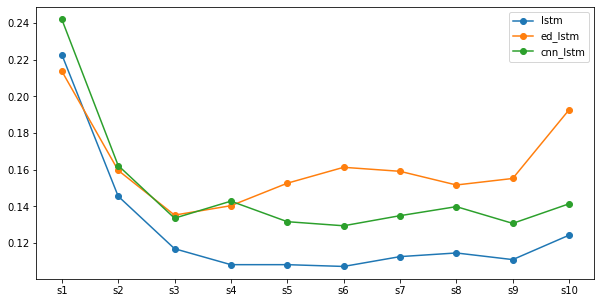

In [18]:
predictions_LSTM, predictions_ED, predictions_CNN = generate_prediction()

In [29]:
predictions_LSTM.shape

(14991, 10)

In [51]:
def struct_10step_predict(predictions):
    #convert array of prediction into a dataframe for 5 step forecasting
    predictionDF = pd.DataFrame(data=predictions, columns=['s1', 's2', 's3', 's4', 's5', 's6', 's7',
                                                       's8','s9','s10'])
    # place max limit of 1
    predictionDF1 = pd.DataFrame(np.where(predictionDF > 1, 1, predictionDF),columns=['s1', 's2', 's3',
                                                            's4', 's5', 's6', 's7','s8','s9','s10'])
    # place min limit of -1 
    predictionDF2 = pd.DataFrame(np.where(predictionDF1 < -1, -1, predictionDF1),columns=['s1', 's2', 's3',
                                                            's4', 's5', 's6', 's7','s8','s9','s10'])
    # return dataframe
    return predictionDF2

In [52]:
predictionDF = struct_10step_predict(predictions_LSTM)

In [53]:
predictionDF.head()

s1        s2        s3        s4        s5        s6        s7  \
0 -0.095969 -0.090915 -0.068715 -0.079450 -0.089576 -0.074694 -0.079441   
1 -0.095227 -0.092167 -0.070576 -0.081046 -0.090378 -0.073782 -0.077420   
2 -0.097182 -0.093545 -0.071542 -0.081731 -0.091080 -0.074847 -0.078813   
3 -0.098011 -0.094230 -0.072138 -0.082413 -0.091852 -0.075779 -0.079787   
4 -0.098301 -0.094456 -0.072338 -0.082859 -0.092461 -0.076634 -0.080720   

         s8        s9       s10  
0 -0.092864 -0.084714 -0.100522  
1 -0.089740 -0.080765 -0.097456  
2 -0.091786 -0.083373 -0.100188  
3 -0.092901 -0.084594 -0.101270  
4 -0.093847 -0.085484 -0.101738

In [54]:
predictionDF.describe()

s1            s2            s3            s4            s5  \
count  14991.000000  14991.000000  14991.000000  14991.000000  14991.000000   
mean       0.061641      0.040716      0.051501      0.085521      0.096926   
std        0.477173      0.508180      0.514650      0.531375      0.527931   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.279393     -0.304942     -0.288117     -0.274805     -0.268549   
50%        0.100757      0.123797      0.132891      0.150203      0.152624   
75%        0.510035      0.506499      0.518103      0.575058      0.586445   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 s6            s7            s8            s9           s10  
count  14991.000000  14991.000000  14991.000000  14991.000000  14991.000000  
mean       0.113081      0.113440      0.087236      0.074899      0.062422  
std        0.549455      0.542094      0.541408      0.518380      0.488059  
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000  
25%       -0.267749     -0.263114     -0.284007     -0.281021     -0.280357  
50%        0.162442      0.164276      0.127831      0.122572      0.111422  
75%        0.625676      0.618096      0.593355      0.555242      0.518176  
max        1.000000      1.000000      1.000000      1.000000      1.000000

In [30]:
# read data from the file
dataset = pd.read_csv('trainData_set1.csv')
# extracting a single feature
X0 = dataset.BIDASKIMBALANCE

In [31]:
X1 = X0[30000:45000]

In [32]:
len(X0[15000:30000])

15000

In [35]:
test = rolling_window(X1.values, 10)

In [36]:
test.shape

(14991, 10)

In [39]:
testDF = pd.DataFrame(data=test,columns=['h9','h8', 'h7', 'h6', 'h5', 'h4',
                                                       'h3', 'h2','h1','c'])

In [40]:
testDF.head()

h9        h8        h7        h6        h5        h4        h3  \
0 -0.051561 -0.057873 -0.060601 -0.060630 -0.057788 -0.066263 -0.064271   
1 -0.057873 -0.060601 -0.060630 -0.057788 -0.066263 -0.064271 -0.064299   
2 -0.060601 -0.060630 -0.057788 -0.066263 -0.064271 -0.064299 -0.064011   
3 -0.060630 -0.057788 -0.066263 -0.064271 -0.064299 -0.064011 -0.065415   
4 -0.057788 -0.066263 -0.064271 -0.064299 -0.064011 -0.065415 -0.065703   

         h2        h1         c  
0 -0.064299 -0.064011 -0.065415  
1 -0.064011 -0.065415 -0.065703  
2 -0.065415 -0.065703 -0.065958  
3 -0.065703 -0.065958 -0.065818  
4 -0.065958 -0.065818 -0.065734

In [41]:
testDF.tail(10)

h9        h8        h7        h6        h5        h4        h3  \
14981  0.678490  0.678515  0.678643  0.678648  0.678669  0.678689  0.678710   
14982  0.678515  0.678643  0.678648  0.678669  0.678689  0.678710  0.679041   
14983  0.678643  0.678648  0.678669  0.678689  0.678710  0.679041  0.681139   
14984  0.678648  0.678669  0.678689  0.678710  0.679041  0.681139  0.681164   
14985  0.678669  0.678689  0.678710  0.679041  0.681139  0.681164  0.681266   
14986  0.678689  0.678710  0.679041  0.681139  0.681164  0.681266  0.681369   
14987  0.678710  0.679041  0.681139  0.681164  0.681266  0.681369  0.681374   
14988  0.679041  0.681139  0.681164  0.681266  0.681369  0.681374  0.681604   
14989  0.681139  0.681164  0.681266  0.681369  0.681374  0.681604  0.681614   
14990  0.681164  0.681266  0.681369  0.681374  0.681604  0.681614  0.680027   

             h2        h1         c  
14981  0.679041  0.681139  0.681164  
14982  0.681139  0.681164  0.681266  
14983  0.681164  0.681266  0.681369  
14984  0.681266  0.681369  0.681374  
14985  0.681369  0.681374  0.681604  
14986  0.681374  0.681604  0.681614  
14987  0.681604  0.681614  0.680027  
14988  0.681614  0.680027  0.685157  
14989  0.680027  0.685157  0.686445  
14990  0.685157  0.686445  0.686487

In [42]:
cols = testDF.columns.tolist()

In [43]:
cols = cols[::-1]

In [44]:
cols

['c', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9']

In [45]:
testDF = testDF[cols] 

In [46]:
testDF.tail(10)

c        h1        h2        h3        h4        h5        h6  \
14981  0.681164  0.681139  0.679041  0.678710  0.678689  0.678669  0.678648   
14982  0.681266  0.681164  0.681139  0.679041  0.678710  0.678689  0.678669   
14983  0.681369  0.681266  0.681164  0.681139  0.679041  0.678710  0.678689   
14984  0.681374  0.681369  0.681266  0.681164  0.681139  0.679041  0.678710   
14985  0.681604  0.681374  0.681369  0.681266  0.681164  0.681139  0.679041   
14986  0.681614  0.681604  0.681374  0.681369  0.681266  0.681164  0.681139   
14987  0.680027  0.681614  0.681604  0.681374  0.681369  0.681266  0.681164   
14988  0.685157  0.680027  0.681614  0.681604  0.681374  0.681369  0.681266   
14989  0.686445  0.685157  0.680027  0.681614  0.681604  0.681374  0.681369   
14990  0.686487  0.686445  0.685157  0.680027  0.681614  0.681604  0.681374   

             h7        h8        h9  
14981  0.678643  0.678515  0.678490  
14982  0.678648  0.678643  0.678515  
14983  0.678669  0.678648  0.678643  
14984  0.678689  0.678669  0.678648  
14985  0.678710  0.678689  0.678669  
14986  0.679041  0.678710  0.678689  
14987  0.681139  0.679041  0.678710  
14988  0.681164  0.681139  0.679041  
14989  0.681266  0.681164  0.681139  
14990  0.681369  0.681266  0.681164

In [55]:
predictionDF.tail(10)

s1        s2        s3        s4        s5        s6        s7  \
14981  0.582406  0.574332  0.578939  0.636386  0.652291  0.694233  0.688812   
14982  0.582728  0.574724  0.579339  0.636913  0.652689  0.694456  0.688903   
14983  0.583012  0.575094  0.579737  0.637452  0.653128  0.694757  0.689077   
14984  0.583207  0.575392  0.580098  0.637955  0.653594  0.695160  0.689372   
14985  0.583256  0.575573  0.580365  0.638345  0.654029  0.695634  0.689779   
14986  0.583251  0.575689  0.580575  0.638639  0.654431  0.696155  0.690282   
14987  0.583293  0.575782  0.580722  0.638779  0.654717  0.696614  0.690801   
14988  0.583281  0.575658  0.580594  0.638472  0.654633  0.696825  0.691239   
14989  0.584113  0.576333  0.581158  0.638974  0.655004  0.697025  0.691454   
14990  0.585285  0.577326  0.582015  0.639857  0.655588  0.697205  0.691510   

             s8        s9       s10  
14981  0.664504  0.622478  0.586541  
14982  0.664520  0.622422  0.586568  
14983  0.664604  0.622401  0.586590  
14984  0.664793  0.622445  0.586603  
14985  0.665091  0.622568  0.586593  
14986  0.665507  0.622817  0.586648  
14987  0.666016  0.623249  0.586886  
14988  0.666591  0.623913  0.587369  
14989  0.666931  0.624441  0.588118  
14990  0.667058  0.624782  0.588890

In [56]:
consolidateDF = pd.DataFrame(testDF['c']).join(predictionDF)

In [57]:
consolidateDF.tail()

c        s1        s2        s3        s4        s5        s6  \
14986  0.681614  0.583251  0.575689  0.580575  0.638639  0.654431  0.696155   
14987  0.680027  0.583293  0.575782  0.580722  0.638779  0.654717  0.696614   
14988  0.685157  0.583281  0.575658  0.580594  0.638472  0.654633  0.696825   
14989  0.686445  0.584113  0.576333  0.581158  0.638974  0.655004  0.697025   
14990  0.686487  0.585285  0.577326  0.582015  0.639857  0.655588  0.697205   

             s7        s8        s9       s10  
14986  0.690282  0.665507  0.622817  0.586648  
14987  0.690801  0.666016  0.623249  0.586886  
14988  0.691239  0.666591  0.623913  0.587369  
14989  0.691454  0.666931  0.624441  0.588118  
14990  0.691510  0.667058  0.624782  0.588890

In [58]:
consolidateDF.to_csv('batch3.csv')

In [59]:
testDF.to_csv('batch3a.csv')

In [60]:
(testDF.values).shape

(14991, 10)

In [61]:
X1[-10:]

44990    0.681164
44991    0.681266
44992    0.681369
44993    0.681374
44994    0.681604
44995    0.681614
44996    0.680027
44997    0.685157
44998    0.686445
44999    0.686487
Name: BIDASKIMBALANCE, dtype: float64

In [ ]:
len()